In [51]:
import warnings
warnings.filterwarnings("ignore")
import math
import modulesForCalibration_VG_XI as mfc

from scipy.stats import norm
import readPlotOptionSurface_granular_typeXII as marketSurface 
import GridPlotFull_V6 as fullgrid
import readPlotOptionSurface_o
import numpy as np
import pandas as pd
import datetime

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sympy import *

from matplotlib import cm
import cmath
import math
from scipy.optimize import fmin

import plotly.plotly as py
import plotly.graph_objs as go

# The Market Grid 

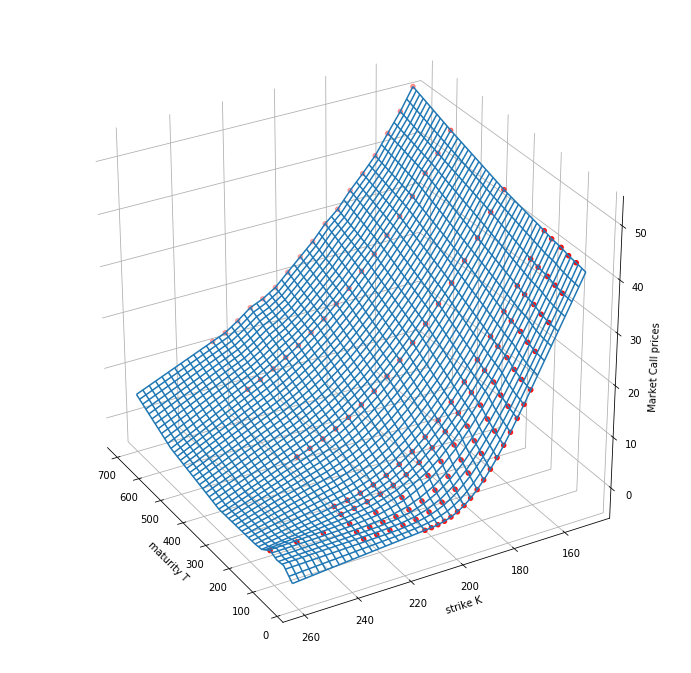

In [48]:
fullgrid.readNPlot('APPL', 'Call')

### Global Parameters

In [52]:
# Parameters
alpha = 1.5
eta = 0.2
n = 12

# Model
model = 'GBM'
# risk free rate
r = 0.0245
# dividend rate
q = 0.005
# spot price
S0 = 190.3

# I. Market Prices

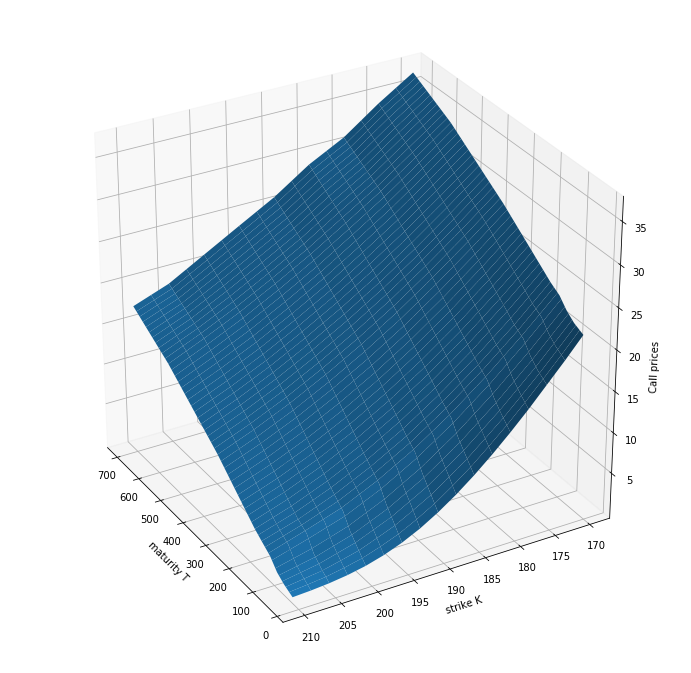

In [53]:
maturities, strikes, callPrices, realPrices = marketSurface.readNPlot('APPL', 'Call')
maturities_years = maturities/365

In [291]:
# select strike and maturity & corresponding option price
T_days = maturities[4]
T = maturities_years[4]
K = strikes[6]
c = callPrices[4][6]

print("For maturity T=%d (days) and strike K=%d, call price is %2.3f" %(T_days, K, c))

For maturity T=53 (days) and strike K=165, call price is nan


# II. Implied Volatlity Surface 

### 1. IV for one maturity

In [7]:
sigArray = []
cArray = []

# implied volatility via grid search
# just for illustrative purposes
# there are much more efficient ways of doing it
eMin = 1.0e6
for sig in mfc.myRange(0.01,0.40,0.005):
    
    params = []
    params.append(sig)
    
    km, cT_km = mfc.genericFFT(params, S0, K, r, q, T, alpha, eta, n, model)
    cHat = cT_km[0]
    
    sigArray.append(sig)
    cArray.append(cHat)
    
    e = abs(cHat-c)
    if (e < eMin):
        eMin = e
        impliedVol = sig
        #print(eMin)
        #print(impliedVol)
        #print(' ')
    
print('Implied vol = ' + str(impliedVol))

Implied vol = 0.3700000000000002


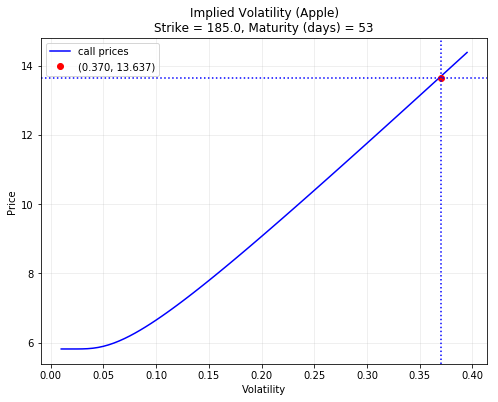

In [8]:
#plot
fig = plt.figure(figsize=(8,6))
plt.plot(sigArray, cArray, 'b')
plt.plot(impliedVol, c, 'ro')
plt.axhline(y=c, color='b', linestyle=':')
plt.axvline(x=impliedVol, color='b', linestyle=':')
plt.grid(alpha=0.25)
plt.xlabel('Volatility')
plt.ylabel('Price')
plt.title('Implied Volatility (Apple)\nStrike = %1.1f, Maturity (days) = %i' % (K, T_days))
leg = ['call prices', '(%1.3f, %1.3f)' % (impliedVol, c)]
plt.legend(leg)
#plt.savefig('impliedVolCall.png')
plt.show()

In [56]:
n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (math.log10(S/K)+(r+(v**2)/2.)*T)/(v*T**0.5)
    d2 = d1-v*T**0.5
    if cp_flag == 'c':
        price = S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    else:
        price = K*np.exp(-r*T)*N(-d2)-S*np.exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (math.log10(S/K)+(r+v*v/2.)*T)/(v*math.sqrt(T))
    vega = S * math.sqrt(T)*n(d1)
    vega
    return vega

In [57]:
def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = float(target_value) - float(price)  # our root

        #print (i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [58]:
V_market = callPrices[4][6]
T = maturities_years[4]
K = strikes[6]
cp = 'c' # call option

implied_vol = find_vol(V_market, cp, S0, K, T, r)
print ('Implied vol: %.2f%%' % (implied_vol * 100))
print ('Market price = %.2f' % V_market)
print ('Model price = %.2f' % bs_price(cp, S0, K, T, r, implied_vol))

Implied vol: 36.76%
Market price = 13.64
Model price = 13.64


In [59]:
callPrices.shape

(17, 97)

## 2. IV for all maturities 

In [60]:
def implied_vol_surface(S,r,cp,prices, maturities, strikes):
    lenT = len(maturities)
    lenK = len(strikes)
    IV = np.zeros((lenT, lenK))

    for i in range(lenT):
        for j in range(lenK):
            T = maturities[i]
            K = strikes[j]
            V_market = prices[i][j]
            iv = find_vol(V_market, cp, S, K, T, r)
            IV[i,j] = iv   
    return IV

In [61]:
iv = implied_vol_surface(S0,r,cp,interpCP.transpose(), maturities_years, strikes)

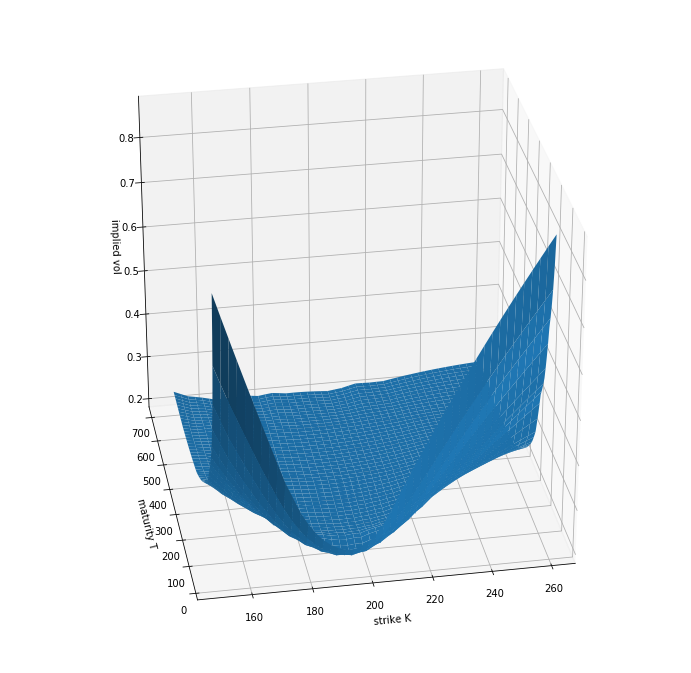

In [303]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, iv)
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('implied vol')
ax.view_init(30, 260)
plt.show()

# -- Testing --

In [123]:
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm

from scipy import interpolate
#from scipy.stats import norm
import Clean_Datasets_flexible

stock = 'APPL'  
otype = 'Call'
option_type = otype 
deltaK = 2.5

# Choose Data & define strikes and maturities -> calibrate for smooth surface
# The Grids need adjustments to get a clean surface around the end points
if (stock == 'APPL'):
    excel_file = '/Users/albanzapke/Desktop/Comp_Methods_Hirsa/data_apple.xlsx'
    df = pd.read_excel(excel_file)
    strikes = np.arange(170., 210 + deltaK , deltaK)
    maturities = np.sort(df.Maturity_days.unique())

# STILL NEED TO THINK ABOUT CLEAN AMZN SURFACE (!)
elif (stock == 'AMZN'):
    df = Clean_Datasets_flexible.clean_merged_data(stock)
    strikes = np.arange(min(df.Strike.unique()), max(df.Strike.unique()) + deltaK , deltaK)
    maturities = np.sort(df.Maturity_days.unique())

elif (stock == 'FB'):
    df = Clean_Datasets_flexible.clean_merged_data(stock)
    strikes = np.arange(min(df.Strike.unique()), 205 + deltaK , deltaK)
    maturities = np.sort(df.Maturity_days.unique())

elif (stock == 'MSFT'):
    df = Clean_Datasets_flexible.clean_merged_data(stock)
    if option_type == 'Put':
        strikes = np.arange(min(df.Strike.unique()), 142.5 + deltaK , deltaK)
    elif option_type == 'Call':
        strikes = np.arange(85., max(df.Strike.unique()) + deltaK , deltaK)
    maturities = np.sort(df.Maturity_days.unique())

# create the 'Mid' variable
df['Mid'] = df[['Bid','Ask']].mean(axis=1)

# 1.) FIRST YOU DO INTERPOLATION FOR STRIKES with fixed Maturity
df_calls = df[df['Option_type'] == option_type][['Maturity_days', 'Strike', 'Mid']]
df_calls.head()

,Maturity_days,Strike,Mid
0,25,170.0,21.275000
1,25,172.5,18.849991
2,25,175.0,16.549995
3,25,177.5,14.250000
4,25,180.0,12.100000


In [260]:
# Define granularity of grid on the maturity axis: -> here weekly 
deltaT = 1
wm = maturities/7
lenT = wm[-1]-wm[0]
maturities_weeks = wm[0] + deltaT * np.arange(lenT+1) 
maturities_year = maturities_weeks/52

# However we cannot index floating maturities, thus need integer values!
int_maturities = []
for i in maturities_weeks:
    int_maturities = np.append(int_maturities, int(i*7))

# define the new and final grid for the second more granular surface
X, Y = np.meshgrid(strikes, int_maturities)
callPrices = pd.DataFrame(np.empty([len(strikes), len(int_maturities)]).fill(np.nan), columns = int_maturities, index=strikes)
callPrices = callPrices.transpose()

In [214]:
for i in maturities:
    callPrices.loc[i] = df_calls[df_calls['Maturity_days'] == i][['Mid']].values.flatten()

In [261]:
for row in df_calls.itertuples():
        strike = row[2]
        maturity = row[1]
        price = row[3]
        try: 
            callPrices.loc[maturity,strike] = price
        except:
              pass

In [263]:
callPrices
callPrices.reindex(columns=sorted(callPrices.columns))

,150.0,155.0,160.0,165.0,170.0,172.5,175.0,177.5,180.0,182.5,...,205.0,207.5,210.0,215.0,220.0,225.0,230.0,240.0,250.0,260.0
25.0,NaN,NaN,NaN,NaN,21.275,18.85,16.55,14.25,12.1,10.075,...,0.465,0.28,0.165,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60.0,41.075001,36.050001,31.250003,26.474999,21.825,NaN,17.4,NaN,13.35,NaN,...,1.395,NaN,0.725,0.375,0.195,0.125,0.070,NaN,NaN,NaN
67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88.0,41.325001,36.475000,31.700000,27.075000,22.6,NaN,18.375,NaN,14.5,NaN,...,2.3,NaN,1.38,0.820,0.490,0.295,0.185,NaN,NaN,NaN


In [63]:
dataVOL = [go.Surface(x=strikes, y=maturities,
    z=iv.tolist(), colorscale='Viridis')]
layout = go.Layout(
    width=800,
    height=700,
    autosize=False,
    title='4-Volatility-Surfaces',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            ticks='outside'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    )
)

fig = dict(data=dataVOL, layout=layout)
py.iplot(fig, filename='4-Vol-Surfaces')